In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds
from nolitsa import lyapunov,dimension,delay,noise

# Se importa el data set de Europa

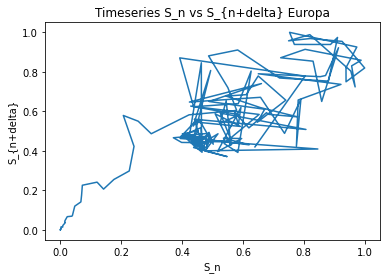

In [2]:
data2 = pd.read_excel (r'C:\Users\javie\Desktop\Modelamiento\Datos\de maass\CONTINENTES-2-CursoMM.xlsx')
df = pd.DataFrame(data2, columns= ['PacíficoOestenew','Américanew','Europanew'])
delta=4
#Europa
timeseries=np.array(df.Europanew)[:-3]
timeseriesd=np.array(df.Europanew)[delta:-3]
timeseries=np.delete(timeseries, 164, axis=0)
timeseriesd=np.delete(timeseriesd, 164-delta, axis=0)
X=timeseries/max(timeseries)
Y=timeseriesd/max(timeseriesd)
plt.figure()
plt.plot(X[:-delta],Y)
plt.title('Timeseries S_n vs S_{n+delta} Europa')
plt.ylabel('S_{n+delta}')
plt.xlabel('S_n')
plt.show()

# Estimaciones de exponentes de lyapunov para la timeseries de casos diarios RM. (Utilizando la libreria nolitsa).

In [3]:
#Funcion util para encontrar minimos locales.
def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1

# Estimación: Tiempo de retardo óptimo.

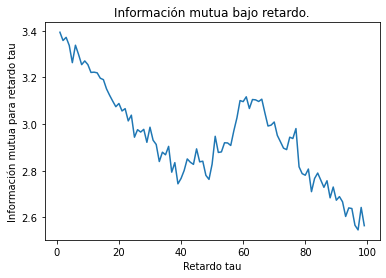

In [4]:
#Calculo de la información mutua entre X_t, X_(t+tau)
time_delay=np.zeros(99)
for tau in range(1,100):
    td=delay.mi(X[:-tau],X[tau:])
    time_delay[tau-1]=td
plt.plot(range(1,100),time_delay)
plt.title('Información mutua bajo retardo.')
plt.xlabel('Retardo tau')
plt.ylabel('Información mutua para retardo tau')
plt.show()

In [5]:
print('Los mínimos locales se alcanzan para tau='+ str(localmin(time_delay)+1))

Los mínimos locales se alcanzan para tau=[ 2  5  8 11 19 21 23 25 27 29 33 35 37 39 44 46 49 52 56 60 62 65 68 74
 76 80 82 86 88 90 93 97]


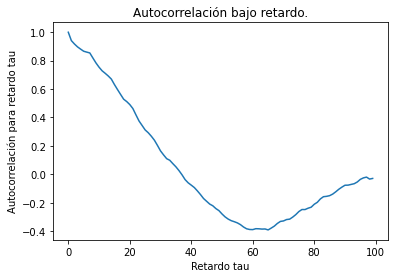

In [6]:
r = delay.acorr(X, maxtau=100)
plt.plot(range(0,100),r)
plt.title('Autocorrelación bajo retardo.')
plt.xlabel('Retardo tau')
plt.ylabel('Autocorrelación para retardo tau')
plt.show()

In [7]:
print('Los mínimos locales se alcanzan para tau='+str(localmin(r)))

Los mínimos locales se alcanzan para tau=[60 63 65 77 98]


# Estimación: Dimensión de inmersión.

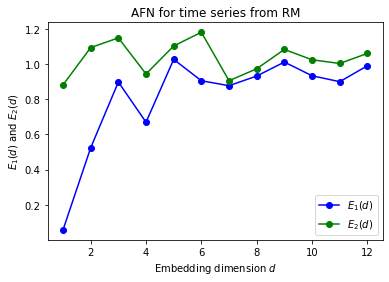

In [8]:
# AFN algorithm.
dim = np.arange(1, 12+ 2)
E, Es = dimension.afn(X, tau=2, dim=dim, window=10)
E1, E2 = E[1:] / E[:-1], Es[1:] / Es[:-1]

plt.title(r'AFN for time series from RM')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'$E_1(d)$ and $E_2(d)$')
plt.plot(dim[:-1], E1, 'bo-', label=r'$E_1(d)$')
plt.plot(dim[:-1], E2, 'go-', label=r'$E_2(d)$')
plt.legend()

plt.show()

# Estimación: Exponente de Lyapunov.

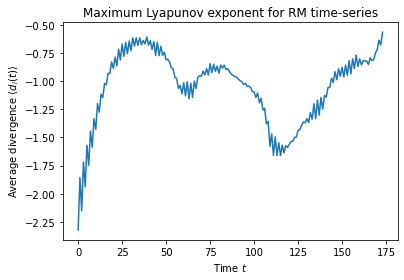

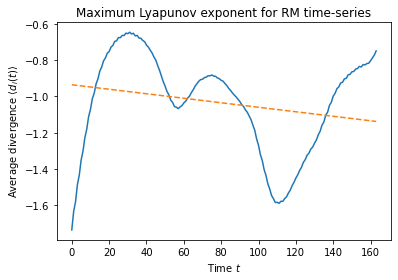

Linear fitting coeficient=-0.0012398648757452522


In [9]:
LEs=lyapunov.mle_embed(X, dim=[9], tau=2, window=10, maxt=300)[0]
plt.plot(range(len(LEs)),LEs)
plt.title('Maximum Lyapunov exponent for RM time-series')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.show()

sma=noise.sma(LEs, hwin=5)
plt.title('Maximum Lyapunov exponent for RM time-series')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(range(len(sma)),sma)
p = np.polyfit(range(len(sma)), sma,deg=1)
xaxis = range(len(sma))
yaxis = p[1] + p[0] * xaxis
plt.plot(xaxis, yaxis, '--')
plt.show()
print('Linear fitting coeficient='+str(p[0]))
MLE_nolitsa=p[0]

In [10]:
MLE_nolds=nolds.lyap_r(X, emb_dim=8, lag=2, min_tsep=10, tau=1, 
                 min_neighbors=20, trajectory_len=20, fit='RANSAC', 
                 debug_plot=False, debug_data=False, plot_file=None, fit_offset=0)

In [11]:
print("Valor obtenido de MLE con nolitsa: "+str(MLE_nolitsa))
print("Valor obtenido de MLE con nolds: "+str(MLE_nolds))

Valor obtenido de MLE con nolitsa: -0.0012398648757452522
Valor obtenido de MLE con nolds: 0.07915284364743337


En la libreria nolitsa esta el siguiente comentario: "It is also important to choose an appropriate Theiler window so that
    the near neighbors do not lie on the same trajectory, in which case
    the estimated MLE will always be close to zero", pues es posible que este sea el problema.